In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

# ========= Config =========
DATA_DIR = "./bird_or_not"   # <- change to your root folder that has 'birds' and 'forest'
IMG_SIZE = 128               # any size works (AdaptiveAvgPool handles it)
BATCH = 64
EPOCHS = 5
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

# ========= Transforms =========
# Ensure RGB, resize, augment a little for training, normalize to [0,1] (simple)
train_tfms = transforms.Compose([
    transforms.Lambda(lambda im: im.convert("RGB")),   # handle grayscale files safely
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
val_tfms = transforms.Compose([
    transforms.Lambda(lambda im: im.convert("RGB")),
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
])

# ========= Dataset & Split =========
full_ds = ImageFolder(DATA_DIR, transform=train_tfms)  # temp transform; we'll swap for val split
num_classes = len(full_ds.classes)
assert num_classes == 2, f"Expected 2 classes, found {num_classes} in {DATA_DIR}. Folders should be e.g. 'birds' and 'forest'."

n_total = len(full_ds)
n_val = max(1, int(0.2 * n_total))
n_train = n_total - n_val
g = torch.Generator().manual_seed(SEED)
train_ds, val_ds = random_split(full_ds, [n_train, n_val], generator=g)

# give the validation set its own deterministic transforms
val_ds.dataset = ImageFolder(DATA_DIR, transform=val_tfms)

# ========= Loaders =========
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)

print("Classes:", full_ds.classes)  # e.g., ['birds', 'forest']

# ========= Model (3 conv layers, then global avg pool) =========
class TinyCNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        # Same 3-layer pattern as your MNIST net, but 3 input channels (RGB)
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)    # 3 -> 8
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)   # 8 -> 16
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # 16 -> 32
        self.pool  = nn.MaxPool2d(2)                              # halves H,W
        self.gap   = nn.AdaptiveAvgPool2d((1, 1))                 # (N,32,1,1)
        self.fc    = nn.Linear(32, num_classes)                   # 32 -> 2

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # H/2
        x = self.pool(F.relu(self.conv2(x)))   # H/4
        x = self.pool(F.relu(self.conv3(x)))   # H/8
        x = self.gap(x)                        # (N,32,1,1)
        x = x.view(x.size(0), -1)              # (N,32)
        x = self.fc(x)                         # (N,2)
        return x

model = TinyCNN(num_classes=2).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()

# ========= Training =========
for epoch in range(1, EPOCHS+1):
    model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            preds = model(xb)
            correct += (preds.argmax(1) == yb).sum().item()
            total += yb.size(0)

    print(f"epoch {epoch:02d} | train loss {total_loss/len(train_loader):.4f} | val acc {correct/total:.3f}")

# ========= Inference helper on a single image =========
from PIL import Image

infer_tfms = val_tfms  # same as validation transforms

idx_to_class = {v:k for k,v in full_ds.class_to_idx.items()}

def predict_image(path):
    model.eval()
    img = Image.open(path)
    x = infer_tfms(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        logits = model(x)
        prob = torch.softmax(logits, dim=1)[0]
        pred_idx = int(prob.argmax().item())
        pred_class = idx_to_class[pred_idx]
        return pred_class, float(prob[pred_idx])

# Example:
# print(predict_image("./data/nature/birds/some_bird.jpg"))


Classes: ['bird', 'forest']
epoch 01 | train loss 0.6197 | val acc 0.694
epoch 02 | train loss 0.5543 | val acc 0.694
epoch 03 | train loss 0.5579 | val acc 0.694
epoch 04 | train loss 0.5485 | val acc 0.694
epoch 05 | train loss 0.5477 | val acc 0.694


In [ ]:
# In this block we will apply our toy 3 CNN to use for classifying between bird and 
#forrest images. Remember we have used it for MNIST hand written digit recognition 
# purpose before.

In [15]:
from PIL import Image
import torch

def predict_image(path):
    model.eval()
    img = Image.open(path)
    x = infer_tfms(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        logits = model(x)
        prob = torch.softmax(logits, dim=1)[0]
        pred_idx = int(prob.argmax().item())
        pred_class = idx_to_class[pred_idx]
        return pred_class, float(prob[pred_idx])

# Example usage:
print(predict_image("bird.jpg"))
print(predict_image("forest.jpg"))


('bird', 0.8006441593170166)
('bird', 0.7480267286300659)


In [8]:
import matplotlib.pyplot as plt
from PIL import Image

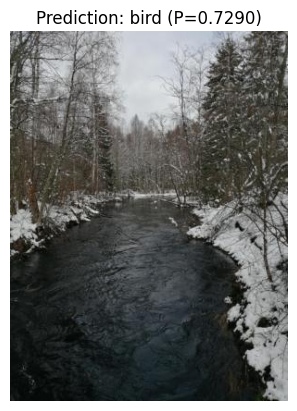

In [16]:
#  Load image (similar to FastAI's PILImage.create)
img_path = "Bird2.jpg"
img = Image.open(img_path).convert("RGB")

#  Apply same transforms as validation/inference
x = infer_tfms(img).unsqueeze(0).to(DEVICE)

#  Get model prediction
model.eval()
with torch.no_grad():
    logits = model(x)
    probs = torch.softmax(logits, dim=1)[0].cpu()
    pred_idx = probs.argmax().item()
    pred_label = idx_to_class[pred_idx]
    pred_prob = probs[pred_idx].item()

#  Display image + prediction
plt.imshow(img)
plt.axis("off")
plt.title(f"Prediction: {pred_label} (P={pred_prob:.4f})")
plt.show()

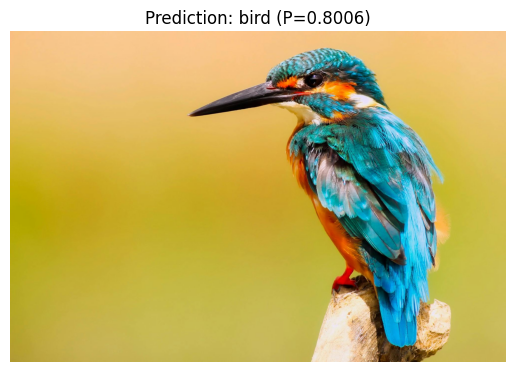

In [13]:
# Load image (similar to FastAI's PILImage.create)
img_path = "bird.jpg"
img = Image.open(img_path).convert("RGB")

#  Apply same transforms as validation/inference
x = infer_tfms(img).unsqueeze(0).to(DEVICE)

# Get model prediction
model.eval()
with torch.no_grad():
    logits = model(x)
    probs = torch.softmax(logits, dim=1)[0].cpu()
    pred_idx = probs.argmax().item()
    pred_label = idx_to_class[pred_idx]
    pred_prob = probs[pred_idx].item()

# Display image + prediction
plt.imshow(img)
plt.axis("off")
plt.title(f"Prediction: {pred_label} (P={pred_prob:.4f})")
plt.show()

In [17]:
# after training, and after you created full_ds, infer_tfms, DEVICE, model
from PIL import Image
import torch

class_to_idx = full_ds.class_to_idx
idx_to_class = {v:k for k,v in class_to_idx.items()}

def get_bird_idx(class_to_idx):
    for name, idx in class_to_idx.items():
        if "bird" in name.lower():   # finds 'bird' regardless of other class name
            return idx
    raise ValueError("No class containing 'bird' found.")
    
bird_idx = get_bird_idx(class_to_idx)

def predict_bird_prob(path):
    model.eval()
    img = Image.open(path).convert("RGB")
    x = infer_tfms(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1)[0].cpu()  # length-2 tensor
    p_bird = float(probs[bird_idx])
    pred_idx = int(probs.argmax().item())
    pred_label = idx_to_class[pred_idx]
    pred_prob = float(probs[pred_idx])
    return p_bird, pred_label, pred_prob


In [18]:
p_bird, pred_label, pred_prob = predict_bird_prob("forest.jpg")
print(f"P(bird) = {p_bird:.4f} | predicted: {pred_label} (P={pred_prob:.4f})")
# For a strict yes/no:
is_bird = p_bird >= 0.5  # or tune this threshold using your val set

P(bird) = 0.7480 | predicted: bird (P=0.7480)


In [ ]:
# In this block of code we will  use pretrained ResNet 18 weights. 
# We are no more training but 

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt

# ========= CONFIG =========
DATA_DIR = "./bird_or_not"   # root folder that contains 'bird/' and 'forest/' (or 'forrest/')
IMG_SIZE = 224               # ResNet expects 224×224
BATCH = 32
EPOCHS = 15                   # try 5–10 for better results
LR = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

# ========= TRANSFORMS =========
def ensure_rgb(img):
    return img.convert("RGB")

train_tfms = transforms.Compose([
    transforms.Lambda(ensure_rgb),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_tfms = transforms.Compose([
    transforms.Lambda(ensure_rgb),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ========= DATASET & LOADERS =========
full_ds = ImageFolder(DATA_DIR, transform=train_tfms)
num_classes = len(full_ds.classes)
print("Classes:", full_ds.classes)

n_val = max(1, int(0.2 * len(full_ds)))
n_train = len(full_ds) - n_val
g = torch.Generator().manual_seed(SEED)
train_ds, val_ds = random_split(full_ds, [n_train, n_val], generator=g)
val_ds.dataset = ImageFolder(DATA_DIR, transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=BATCH, shuffle=False, num_workers=0)

# ========= MODEL (Pretrained ResNet18) =========
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
for param in model.parameters():
    param.requires_grad = False  # freeze pretrained layers

model.fc = nn.Linear(model.fc.in_features, num_classes)  # replace final layer
model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.fc.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()

# ========= TRAIN =========
for epoch in range(1, EPOCHS+1):
    model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            preds = model(xb)
            correct += (preds.argmax(1) == yb).sum().item()
            total += yb.size(0)
    print(f"epoch {epoch:02d} | train loss {total_loss/len(train_loader):.4f} | val acc {correct/total:.3f}")

# ========= INFERENCE =========
idx_to_class = {v:k for k,v in full_ds.class_to_idx.items()}
infer_tfms = val_tfms

def predict_bird_prob(path):
    model.eval()
    img = Image.open(path).convert("RGB")
    x = infer_tfms(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1)[0].cpu()
    pred_idx = int(probs.argmax().item())
    pred_label = idx_to_class[pred_idx]
    pred_prob = float(probs[pred_idx])
    return pred_label, pred_prob, probs

# ========= DISPLAY RESULT =========
def show_prediction(path):
    pred_label, pred_prob, probs = predict_bird_prob(path)
    plt.imshow(Image.open(path))
    plt.axis("off")
    plt.title(f"Prediction: {pred_label} (P={pred_prob:.3f})")
    plt.show()
    print("All probabilities:")
    for cls, p in zip(idx_to_class.values(), probs):
        print(f"  {cls:8s}: {float(p):.4f}")

# Example:
# show_prediction("forest.jpg")
# show_prediction("bird.jpg")


Classes: ['bird', 'forest']
epoch 01 | train loss 0.9295 | val acc 0.419
epoch 02 | train loss 0.6394 | val acc 0.710
epoch 03 | train loss 0.5590 | val acc 0.718
epoch 04 | train loss 0.5237 | val acc 0.718
epoch 05 | train loss 0.4705 | val acc 0.766
epoch 06 | train loss 0.4301 | val acc 0.823
epoch 07 | train loss 0.3878 | val acc 0.847
epoch 08 | train loss 0.3539 | val acc 0.927
epoch 09 | train loss 0.3159 | val acc 0.927
epoch 10 | train loss 0.3101 | val acc 0.927
epoch 11 | train loss 0.2836 | val acc 0.944
epoch 12 | train loss 0.2571 | val acc 0.952
epoch 13 | train loss 0.2346 | val acc 0.952
epoch 14 | train loss 0.2198 | val acc 0.968
epoch 15 | train loss 0.2175 | val acc 0.976


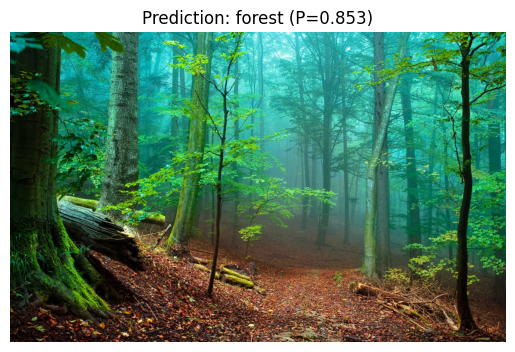

All probabilities:
  bird    : 0.1473
  forest  : 0.8527


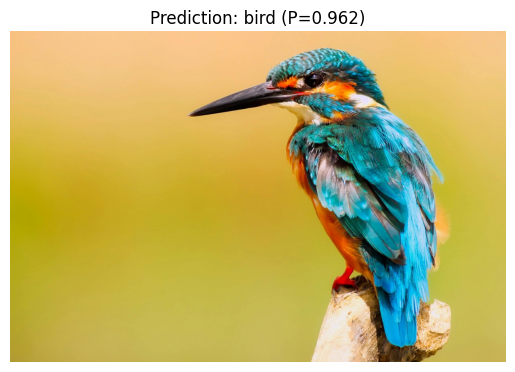

All probabilities:
  bird    : 0.9625
  forest  : 0.0375


In [24]:
 show_prediction("forest.jpg")
 show_prediction("bird.jpg")

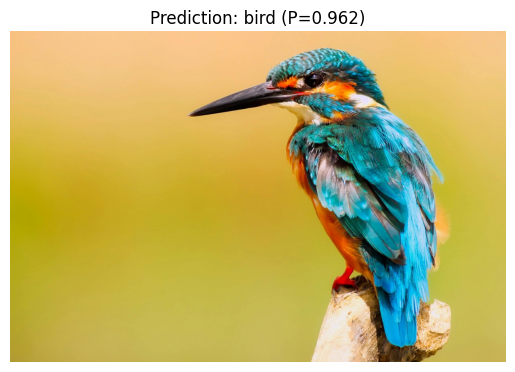

All probabilities:
  bird    : 0.9625
  forest  : 0.0375


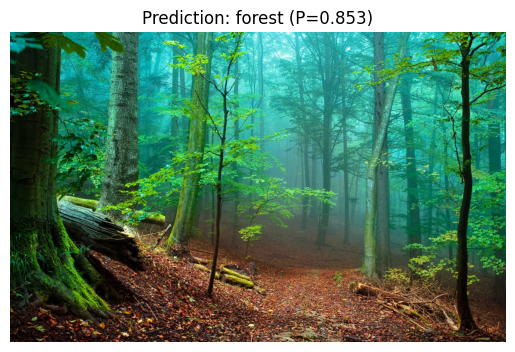

All probabilities:
  bird    : 0.1473
  forest  : 0.8527


In [25]:
 show_prediction("forest1.jpg")
 show_prediction("bird1.jpg")